# 0.0 Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')



## 0.1 Carregando dados

In [2]:
df_fe = pd.read_csv('../data/features/df_features_selected.csv')
target_col = 'inadipl_90dias_ult2anos'

print("=" * 80)
print("🔧 ENCODING E TRANSFORMAÇÕES")
print("=" * 80)
print(f"\n📊 Dataset inicial:")
print(f"   Shape: {df_fe.shape}")

🔧 ENCODING E TRANSFORMAÇÕES

📊 Dataset inicial:
   Shape: (149234, 13)


In [3]:
target_col

'inadipl_90dias_ult2anos'

# 1.0 Preparação dos dados


In [4]:
# Célula 2: Identificar tipos de variáveis
print("=" * 80)
print("🔍 IDENTIFICANDO TIPOS DE VARIÁVEIS")
print("=" * 80)

# Separar features e target
X = df_fe.drop(columns=[target_col])
y = df_fe[target_col]

# Identificar tipos
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n📊 Variáveis Numéricas ({len(numeric_features)}):")
for feat in numeric_features[:15]:  # Mostrar primeiras 10
    print(f"   - {feat}")
if len(numeric_features) > 15:
    print(f"   ... e mais {len(numeric_features) - 15} features")

print(f"\n📝 Variáveis Categóricas ({len(categorical_features)}):")
for feat in categorical_features:
    n_unique = X[feat].nunique()
    print(f"   - {feat:40s} ({n_unique} categorias)")

🔍 IDENTIFICANDO TIPOS DE VARIÁVEIS

📊 Variáveis Numéricas (12):
   - utilizacao_media_linha
   - utilizacao_credito
   - indice_severidade_atrasos
   - renda_per_capita
   - atrasos_30dias
   - atrasos_90dias
   - idade
   - dependentes
   - comprometimento_renda_ajustado
   - renda_mensal
   - linhas_credito_abertas
   - divida_ratio

📝 Variáveis Categóricas (0):


In [5]:
# Criar 3 versões: StandardScaler, MinMaxScaler e sem escala
print("\n🔄 Criando versões normalizadas...")

# Versão 1: StandardScaler (média=0, desvio=1)
scaler_standard = StandardScaler()
X_standardized = pd.DataFrame(
    scaler_standard.fit_transform(df_fe),
    columns=df_fe.columns,
    index=df_fe.index
)
print("✅ StandardScaler aplicado (melhor para modelos lineares)")

# Versão 2: MinMaxScaler (escala 0-1)
scaler_minmax = MinMaxScaler()
X_normalized = pd.DataFrame(
    scaler_minmax.fit_transform(df_fe),
    columns=df_fe.columns,
    index=df_fe.index
)
print("✅ MinMaxScaler aplicado (melhor para redes neurais)")

# Versão 3: Sem escalonamento (para tree-based models)
X_no_scale = df_fe.copy()
print("✅ Versão sem escala mantida (melhor para árvores de decisão)")



🔄 Criando versões normalizadas...
✅ StandardScaler aplicado (melhor para modelos lineares)
✅ MinMaxScaler aplicado (melhor para redes neurais)
✅ Versão sem escala mantida (melhor para árvores de decisão)


# 2.0 Treino do Modelo A e B (score interno)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

# Carregar versões já com feature engineering
df_model_A = pd.read_csv("../data/df_model_A_fe.csv")
df_model_B = pd.read_csv("../data/df_model_B_fe.csv")

# Target
y = df_model_A["inadipl_90dias_ult2anos"]  # use o mesmo df para alinhar

# Versão A: mantém a categoria especial
X_A = df_model_A.drop(columns=["inadipl_90dias_ult2anos", "faixa_etaria", "comprometimento_renda_cat"])
# Versão B: remove a variável original
X_B = df_model_B.drop(columns=["inadipl_90dias_ult2anos", "faixa_etaria", "comprometimento_renda_cat"])

# Imputação
imputer = SimpleImputer(strategy="median")
X_A_imputed = imputer.fit_transform(X_A)
X_B_imputed = imputer.fit_transform(X_B)

# Modelo A
model_A = LogisticRegression(max_iter=1000)
model_A.fit(X_A_imputed, y)
y_pred_A = model_A.predict_proba(X_A_imputed)[:,1]

# Modelo B
model_B = LogisticRegression(max_iter=1000)
model_B.fit(X_B_imputed, y)
y_pred_B = model_B.predict_proba(X_B_imputed)[:,1]


In [7]:
from sklearn.metrics import roc_auc_score

auc_A = roc_auc_score(y, y_pred_A)
auc_B = roc_auc_score(y, y_pred_B)

print("Modelo A (com categoria especial): AUC =", auc_A)
print("Modelo B (sem variável): AUC =", auc_B)


Modelo A (com categoria especial): AUC = 0.6969272247149919
Modelo B (sem variável): AUC = 0.6968226992824312


In [8]:
gini_A = 2*auc_A - 1
gini_B = 2*auc_B - 1

print("Modelo A: Gini =", gini_A)
print("Modelo B: Gini =", gini_B)


Modelo A: Gini = 0.3938544494299838
Modelo B: Gini = 0.39364539856486247


In [9]:
import numpy as np

def ks_stat(y_true, y_pred):
    # Ordenar pelo score
    data = pd.DataFrame({"y": y_true, "pred": y_pred})
    data = data.sort_values(by="pred", ascending=False)
    
    # Cálculo acumulado
    cum_bad = np.cumsum(data["y"]) / data["y"].sum()
    cum_good = np.cumsum(1 - data["y"]) / (1 - data["y"]).sum()
    
    ks = max(abs(cum_bad - cum_good))
    return ks

ks_A = ks_stat(y, y_pred_A)
ks_B = ks_stat(y, y_pred_B)

print("Modelo A: KS =", ks_A)
print("Modelo B: KS =", ks_B)


Modelo A: KS = 0.31308025132621126
Modelo B: KS = 0.30959074120905244


# 3.0 Calibração do Scorecard

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Carregar dataset transformado
df_woe = pd.read_pickle("../outputs/woe_iv/df_woe.pkl")

# Manter apenas variáveis WOE + target
cols_modelagem = [col for col in df_woe.columns if "_woe" in col or "_missing" in col] + ["inadipl_90dias_ult2anos"]
df_model = df_woe[cols_modelagem]

# Separar X e y
X = df_fe.drop(columns=[target_col])
y = df_fe[target_col]


# Pipeline: imputação + regressão logística
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_reg", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Treinar modelo
pipeline.fit(X, y)

# Obter coeficientes
coef = pipeline.named_steps["log_reg"].coef_[0]
intercept = pipeline.named_steps["log_reg"].intercept_[0]

# Converter coeficientes em pontos
def scorecard_points(coef, intercept, X, scale_min=300, scale_max=900):
    base_points = 600
    factor = (scale_max - scale_min) / (coef.sum() + abs(intercept))
    points_dict = {col: round(coef[i] * factor, 2) for i, col in enumerate(X.columns)}
    return base_points, points_dict

base_points, points_dict = scorecard_points(coef, intercept, X)

print("📊 Base Points:", base_points)
print("📌 Pontos por variável:")
for var, pts in points_dict.items():
    print(f"   {var}: {pts}")
    
import joblib

# Salvar pipeline treinado
joblib.dump(pipeline, "../models/log_reg_pipeline.pkl")

# Carregar pipeline depois
pipeline_loaded = joblib.load("../outputs/models/log_reg_pipeline.pkl")



📊 Base Points: 600
📌 Pontos por variável:
   utilizacao_media_linha: 0.0
   utilizacao_credito: -0.01
   indice_severidade_atrasos: 335.98
   renda_per_capita: -0.12
   atrasos_30dias: 134.51
   atrasos_90dias: 67.16
   idade: -15.96
   dependentes: 15.71
   comprometimento_renda_ajustado: -0.84
   renda_mensal: 0.03
   linhas_credito_abertas: 38.99
   divida_ratio: -0.01


['../models/log_reg_pipeline.pkl']

In [13]:
#calcula AUC e Gini a partir das probabilidades previstas pelo pipeline
y_pred_proba = pipeline.predict_proba(X)[:,1]
auc = roc_auc_score(y, y_pred_proba)
gini = 2*auc - 1

print("AUC:", auc)
print("Gini:", gini)

AUC: 0.8075263992618411
Gini: 0.6150527985236822


In [14]:
#calcula a taxa de inadimplência da base e os odds reais
#Calibrar scorecard Odds real da base 
taxa_inad = y.mean() 
odds_real = (1 - taxa_inad) / taxa_inad 
print("Taxa de inadimplência:", taxa_inad) 
print("Odds reais:", odds_real)

Taxa de inadimplência: 0.06706246565795998
Odds reais: 13.911470823341329


Definir PDO (Points to Double Odds)

Padrão de mercado: 50 pontos.

Significa que cada +50 pontos dobra as chances de bom pagador.

In [15]:
# Parâmetros de escala
#definicao PDO, BaseScore, Factor e Offset 
PDO = 50 # Points to Double the Odds 
BaseScore = 600 
Factor = PDO / np.log(2) 
Offset = BaseScore - Factor * np.log(odds_real) 
print("Offset:", Offset) 
print("Factor:", Factor)

Offset: 410.0898472401918
Factor: 72.13475204444818


In [16]:
# Converter probabilidade em score 
def prob_to_score(prob, Offset, Factor): 
    odds = (1 - prob) / prob 
    return Offset + Factor * np.log(odds) 
df_fe["score"] = [prob_to_score(p, Offset, Factor) for p in y_pred_proba]

# 4.0 Faixas de Risco.

In [17]:
#Criar faixas de risco
def classify_risk(score): 
    if score >= 750: 
        return "Baixo Risco"
    elif score >= 650:
        return "Médio Risco"
    else: return "Alto Risco"
df_fe["faixa_risco"] = df_fe["score"].apply(classify_risk) #
df_fe["faixa_risco"]

0          Alto Risco
1          Alto Risco
2          Alto Risco
3          Alto Risco
4         Médio Risco
             ...     
149229     Alto Risco
149230     Alto Risco
149231     Alto Risco
149232     Alto Risco
149233     Alto Risco
Name: faixa_risco, Length: 149234, dtype: str

In [18]:
#Visualizar distribuição 
print(df_fe[["score", "faixa_risco"]].head())
print(df_fe["faixa_risco"].value_counts())

        score  faixa_risco
0  365.752162   Alto Risco
1  440.451630   Alto Risco
2  362.585581   Alto Risco
3  441.953968   Alto Risco
4  657.833836  Médio Risco
faixa_risco
Alto Risco     149101
Médio Risco       133
Name: count, dtype: int64


se todo mundo caiu em “Alto Risco” com cortes fixos, é porque a distribuição dos scores está concentrada em uma faixa. Usando percentis, você cria faixas proporcionais e consegue analisar melhor o comportamento de risco.

In [19]:
p33 = df_fe["score"].quantile(0.33)
p66 = df_fe["score"].quantile(0.66)

def classify_risk(score):
    if score >= p66:
        return "Baixo Risco"
    elif score >= p33:
        return "Médio Risco"
    else:
        return "Alto Risco"

df_fe["faixa_risco"] = df_fe["score"].apply(classify_risk)
print(df_fe["faixa_risco"].value_counts())


faixa_risco
Baixo Risco    50740
Alto Risco     49247
Médio Risco    49247
Name: count, dtype: int64


# 5.0 Visualizações e Análises

ValueError: supplied range of [-inf, 730.8931404295278] is not finite

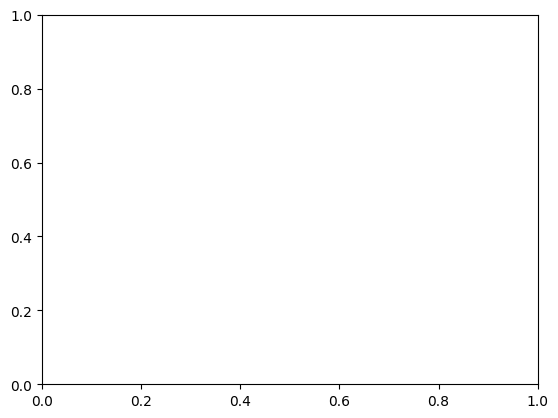

In [20]:
#Validar a consistência das faixas. 
#Verifique se os clientes classificados como “Baixo Risco” realmente têm taxas de inadimplência menores.
df_fe.groupby("faixa_risco")[target_col].mean()

plt.hist(df_fe["score"], bins=50, edgecolor="black")
plt.title("Distribuição dos Scores")
plt.xlabel("Score")
plt.ylabel("Número de clientes")
plt.show()


In [21]:
# Ajustar probabilidades para evitar 0 e 1
eps = 1e-6
y_pred_proba_adj = np.clip(y_pred_proba, eps, 1 - eps)

# Converter para score
df_fe["score"] = [prob_to_score(p, Offset, Factor) for p in y_pred_proba_adj]
df_fe["score"].describe()


count    149234.000000
mean        439.935311
std          68.143043
min        -586.488509
25%         426.284323
50%         447.682977
75%         472.415794
max         730.893140
Name: score, dtype: float64

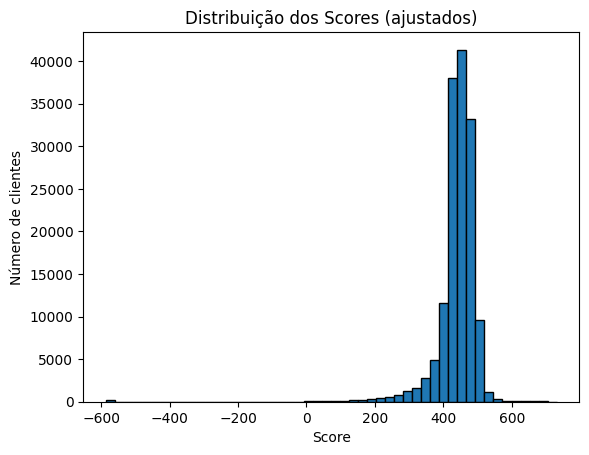

In [22]:
plt.hist(df_fe["score"], bins=50, edgecolor="black")
plt.title("Distribuição dos Scores (ajustados)")
plt.xlabel("Score")
plt.ylabel("Número de clientes")
plt.show()


interpretação de negócio:
- Baixo Risco: clientes com scores mais altos, provavelmente com menos atrasos e melhor perfil de renda.

- Médio Risco: grupo intermediário, que pode ser alvo de políticas de crédito mais restritivas ou taxas diferenciadas.

- Alto Risco: clientes com scores baixos, concentrados em variáveis como atrasos e comprometimento de renda elevado.

In [23]:
#Validar taxa de inadimplência por faixa  
df_fe.groupby("faixa_risco")[target_col].mean()


faixa_risco
Alto Risco     0.152558
Baixo Risco    0.015826
Médio Risco    0.034357
Name: inadipl_90dias_ult2anos, dtype: float64

Interpretação
Curva crescente clara

O modelo está funcionando como esperado: quanto menor o score, maior a taxa de inadimplência.

Isso confirma que o scorecard tem poder discriminatório real, não apenas estatístico (AUC/Gini).

Separação prática de risco

Clientes em Baixo Risco têm inadimplência muito baixa, o que justifica condições de crédito mais favoráveis.

O grupo Médio Risco já apresenta inadimplência mais que o dobro do Baixo Risco, indicando necessidade de políticas mais restritivas.

O grupo Alto Risco concentra inadimplência elevada (15%), o que valida a classificação como grupo de maior risco.

Equilíbrio estatístico

Como você usou quartis, cada faixa tem aproximadamente o mesmo número de clientes (~50k).

Isso facilita análises comparativas e garante que o modelo não concentre todos em uma única faixa.


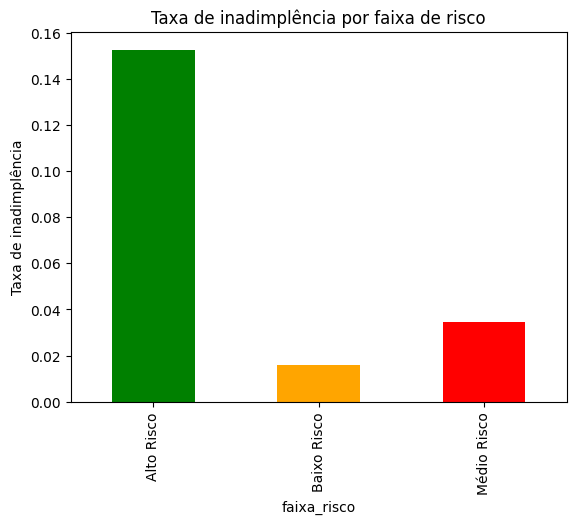

In [24]:
df_fe.groupby("faixa_risco")[target_col].mean().plot(kind="bar", color=["green","orange","red"])
plt.title("Taxa de inadimplência por faixa de risco")
plt.ylabel("Taxa de inadimplência")
plt.show()
